# EDA of Cyanotoxin



In [1]:
%matplotlib inline

from boruta import BorutaPy
import pandas as pd
from itertools import compress
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import keras
# import sklearn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
import tensorflow
from datetime import datetime, timedelta

# sklearn.show_versions()

## Helper functions

In [2]:

def separate_into_training_and_testing_sets(training_set, test_set, quarts):
    from sklearn.model_selection import train_test_split
    xs = training_set.drop(['price'], axis = 1)
    ys = training_set['price']
    bins = training_set.price.quantile(quarts).values
    ys_binned = np.digitize(ys, bins)

    x_training, x_val, y_training, y_val = train_test_split(xs, ys,
                                                            stratify=ys_binned,
                                                            test_size=0.10
                                                           )

    x_test = test_set.drop(['id'], axis = 1)

    return x_training, y_training, x_val, y_val, x_test

def add_boruta_feature(boruta, n):
    '''
    Manually adds the feature at index n to a boruta model
    :param boruta: an SKLearn boruta model
    :param feature: an int for the desired feature index
    :return: the sklearn model with the feature at index n changed to true in boruta.support_
    '''

    boruta.support_[n] = True
    return boruta

def remove_boruta_feature(boruta, n):
    '''
    Manually removes the feature at index n to a boruta model
    :param boruta: an SKLearn boruta model
    :param feature: an int for the desired feature index
    :return: the skearn model with the feature at index n changed to true
    '''
    boruta.support_[n] = False
    boruta.support_weak_ = False
    return boruta

def separate_date_into_mdy(df, col='DATE', drop=False, dropna=False):
    '''

    Separates the date column of a data frame into month, day, and year

    :param df: a pandas data frame
    :param col: a string of the column name containing the dates
    :param drop: a boolean of whether or not to drop col
    :param dropna: a boolean for whether or not to drop rows containing nas in column col
    :return: a pandas data frame containing the three new columns
    '''

    if dropna:
        df.dropna(subset=[col], inplace=True)

    df[col] = df[col].astype('datetime64')

    df['Month'] = df[col].dt.month.astype("int64")
    df['Year'] = df[col].dt.year
    df['Day'] = df[col].dt.day

    # df['Month'] = pd.DatetimeIndex(df[col]).month
    # df['Year'] = pd.DatetimeIndex(df[col]).year
    # df['Day'] = pd.DatetimeIndex(df[col]).day

    if drop:
        del df[col]

    return df

def generate_rolling_mean(df, col, window, rm_col_name, group_by_var, min_periods=1):
    '''
    Creates a new column in the data frame of the rolling mean of a column

    :param df: a pandas data frame
    :param col: a string of the column name to compute the rolling mean for
    :param window: an int for how big the rolling mean window should be
    :param rm_col_name: a string name for the new rolling mean column
    :param group_by_var: a string name for the variable to group by before calculating the rolling mean
    :param min_periods: an int for the minimum number of observations to calculate the rolling mean
    :return: a pandas data frame containing a new column called rm_col_name
    '''

    df[rm_col_name] = df.groupby(group_by_var)[col].rolling(window, min_periods=min_periods).mean().reset_index(0, drop=True)
    return df

def shift_columns(df, col, n, groupvar):
    '''

    :param df: a pandas data frame
    :param col: a string of the column name to shift
    :param n: the number of rows to shift by
    :param groupvar: the variable to group by before shifting rows
    :return: a pandas data frame with an additional column of the shifted values of col
    '''

    new_col_name = '{}_{}_ahead'.format(col, n)
    # df[new_col_name] = df[col].shift(-n)
    df[new_col_name] = df.groupby([groupvar])[col].shift(-n)

    return df

def read_station_lake_dictionary(file_name):
    '''


    :param file_name: the path to a tsv containing lakes and the station nearest to them
    :return: a dictionary with keys the name of the lake and values the nearest station
    '''

    station_lake_map = {}

    with open(file_name) as fin:
        for line in fin:
            line = line.rstrip().split('\t')
            station_lake_map[line[0].rstrip()] = line[1].rstrip()

    return station_lake_map

## Preprocessing: Data Wrangling

### Station Data

The station data was generated from [NOAA](https://www.ncdc.noaa.gov/cdo-web).

In [3]:
station_data = pd.read_csv('./data/station_data.csv')
# station_data = separate_date_into_mdy(station_data, col='DATE')
station_data.dropna(subset=['DATE'], inplace=True)
station_data['DATE'] = station_data['DATE'].astype('datetime64')
station_data = station_data[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE', 'PRCP',
                             # 'AWND', 'EVAP', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'TOBS'
                             ]].dropna()


# for cat in ['PRCP', 'AWND', 'TAVG']:
#     for i in [3, 5, 7]:
#         new_col = '{}d_{}_rm'.format(i, cat)
#         station_data = generate_rolling_mean(station_data, cat, i, new_col, 'STATION')

c:\users\pvill\repos\cyanotoxin_paper\.venv\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7,11,15,23,31,33,35,37,39,41,43,47,57) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Lake data


#### Adding new variables

In [4]:

import sys
lake_data = pd.read_excel('./data/IowaDNR_2019_Data_Merged.xlsx',
                          sheet_name='WK6-15',
                          usecols=[i for i in range(21)],
                          encoding=sys.getfilesystemencoding()
                          )

lake_data.dropna(subset=['Collected Date'], inplace=True)
lake_data['Category'] = lake_data['Category'].astype(np.int64)
lake_data['pH'] = lake_data['pH'].astype(np.float64)
lake_data['Environmental Location'] = lake_data['Environmental Location'].astype(str)

lake_data.dropna(subset=['Collected Date'], inplace=True)
lake_data['Collected Date'] = lake_data['Collected Date'].astype('datetime64')
lake_data['Week'] = lake_data['Label'].str.split('-').str[0].astype(int)
lake_data.drop(['Label', 'Client Reference'], axis=1, inplace=True)

lake_data['TN'] = lake_data['TKN (mg N/L)'] + lake_data['NOx (mg N/L)']
lake_data['TP'] = lake_data['TKP (mg P/L)'] + lake_data['ortho-P (mg P/L)']
lake_data['TN:TP'] = lake_data['TN'] / lake_data['TP']
lake_data['TN:TP Other'] = lake_data['TN'] / lake_data['TKP (mg P/L)']

lake_data['McyA:16s'] = lake_data['mcyA.M'] / lake_data['16S']

lake_data = lake_data.sort_values(by=['Week'])

# for i in range(3):
#     lake_data = shift_columns(lake_data, 'Microcystin', i + 1, 'Environmental Location')

lake_data = shift_columns(lake_data, 'Microcystin', 1, 'Environmental Location')
lake_data = shift_columns(lake_data, 'Category', 1, 'Environmental Location')

lake_data.dtypes

Collected Date            datetime64[ns]
Environmental Location            object
Microcystin                      float64
Cylindrospermopsin               float64
DNA Conc                         float64
16S                              float64
mcyA.M                           float64
mcyA.P                           float64
mcyA.A                           float64
DOC(ppm)                         float64
TKP (mg P/L)                     float64
ortho-P (mg P/L)                 float64
TKN (mg N/L)                     float64
NH3 (mg N/L)                     float64
NOx (mg N/L)                     float64
NO2 (mg N/L)                     float64
Cl (mg Cl/L)                     float64
pH                               float64
Category                           int64
Week                               int32
TN                               float64
TP                               float64
TN:TP                            float64
TN:TP Other                      float64
McyA:16s        

In [5]:
list(lake_data)


['Collected Date',
 'Environmental Location',
 'Microcystin',
 'Cylindrospermopsin',
 'DNA Conc',
 '16S',
 'mcyA.M',
 'mcyA.P',
 'mcyA.A',
 'DOC(ppm)',
 'TKP (mg P/L)',
 'ortho-P (mg P/L)',
 'TKN (mg N/L)',
 'NH3 (mg N/L)',
 'NOx (mg N/L)',
 'NO2 (mg N/L)',
 'Cl (mg Cl/L)',
 'pH',
 'Category',
 'Week',
 'TN',
 'TP',
 'TN:TP',
 'TN:TP Other',
 'McyA:16s',
 'Microcystin_1_ahead',
 'Category_1_ahead']

In [6]:
microcystin_cats = ['Week'] + [col for col in lake_data if col.startswith('Microcystin')]
lake_data.loc[:, microcystin_cats]

,Week,Microcystin,Microcystin_1_ahead
0,6,0.000,0.000
21,6,0.127,0.000
22,6,33.660,45.790
23,6,0.000,0.000
24,6,0.160,0.255
...,...,...,...
340,15,1.892,NaN
341,15,1.150,NaN
342,15,0.172,NaN
344,15,0.358,NaN


## Combining the two dataframes

### Getting a dictionary showing the station nearest each lake

In [7]:
station_lake_map = read_station_lake_dictionary('./data/stations_nearest_lakes')

In [8]:
lake_data['Nearest Station'] = lake_data['Environmental Location'].map(station_lake_map)

In [9]:
combined = pd.merge(lake_data, station_data, how='left',
                    left_on=['Nearest Station', 'Collected Date'],
                    right_on=['STATION', 'DATE'])

In [10]:
list(combined)

['Collected Date',
 'Environmental Location',
 'Microcystin',
 'Cylindrospermopsin',
 'DNA Conc',
 '16S',
 'mcyA.M',
 'mcyA.P',
 'mcyA.A',
 'DOC(ppm)',
 'TKP (mg P/L)',
 'ortho-P (mg P/L)',
 'TKN (mg N/L)',
 'NH3 (mg N/L)',
 'NOx (mg N/L)',
 'NO2 (mg N/L)',
 'Cl (mg Cl/L)',
 'pH',
 'Category',
 'Week',
 'TN',
 'TP',
 'TN:TP',
 'TN:TP Other',
 'McyA:16s',
 'Microcystin_1_ahead',
 'Category_1_ahead',
 'Nearest Station',
 'STATION',
 'NAME',
 'LATITUDE',
 'LONGITUDE',
 'DATE',
 'PRCP']

Check to see that the combined data frame has the correct number of dimensions:

In [11]:
print('{} dims: {}'.format('station_data', station_data.shape))
print('{} dims: {}'.format('lake_data', lake_data.shape))
print('{} dims: {}'.format('combined', combined.shape))




station_data dims: (33339, 6)
lake_data dims: (364, 28)
combined dims: (364, 34)


Pull readings from a lake to make sure that rolling means and microcystin categories are correctly calculated within the groups:


In [12]:
cats_of_interest = microcystin_cats + \
                   ['Collected Date', 'Environmental Location', 'Nearest Station'] + \
                   [col for col in combined.columns if 'rm' in col]

combined[cats_of_interest].\
    loc[combined['Environmental Location'] == 'Nine Eagles Beach']

,Week,Microcystin,Microcystin_1_ahead,Collected Date,Environmental Location,Nearest Station,Cylindrospermopsin
11,6,0.052,0.030,2019-06-26,Nine Eagles Beach,USW00094991,0.014
45,7,0.030,0.327,2019-07-02,Nine Eagles Beach,USW00094991,0.027
82,8,0.327,1.250,2019-07-10,Nine Eagles Beach,USW00094991,0.033
122,9,1.250,0.000,2019-07-17,Nine Eagles Beach,USW00094991,0.018
160,10,0.000,0.023,2019-07-24,Nine Eagles Beach,USW00094991,0.000
195,11,0.023,0.355,2019-07-31,Nine Eagles Beach,USW00094991,0.007
228,12,0.355,0.600,2019-08-07,Nine Eagles Beach,USW00094991,0.008
269,13,0.600,0.052,2019-08-14,Nine Eagles Beach,USW00094991,0.015
303,14,0.052,0.188,2019-08-21,Nine Eagles Beach,USW00094991,0.000
341,15,0.188,NaN,2019-08-28,Nine Eagles Beach,USW00094991,0.000


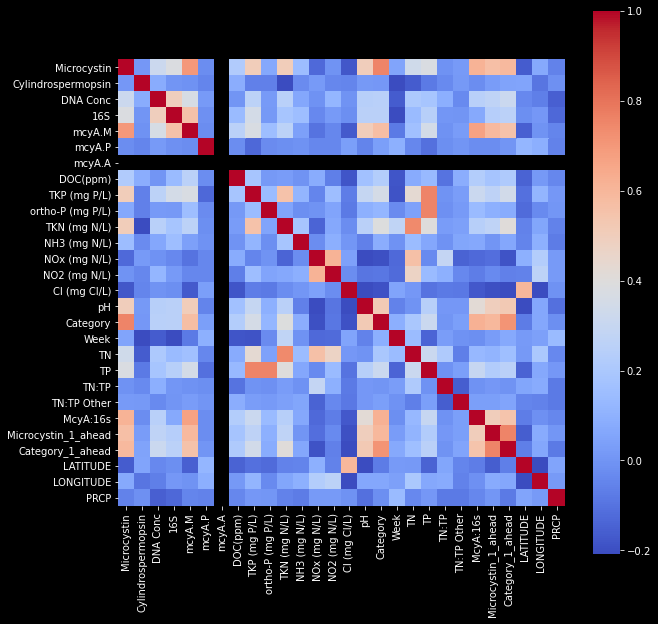

In [13]:
corr_matrix = combined.corr()


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            annot=False,
            cmap='coolwarm',
            robust=True,
            square=True,
            ax=ax);


## Data prep

In [14]:
drop_cats_for_classification = [
                                'Collected Date', 'Environmental Location',
                                'Category', 'Week', 'Nearest Station',
                                'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE',
                                'Microcystin_1_ahead',
                                'Cylindrospermopsin',
                                'DNA Conc',
                                'Microcystin',
                                # '5d_PRCP_rm', '7d_PRCP_rm',
                                # '5d_AWND_rm', '7d_AWND_rm',
                                # '3d_TAVG_rm', '5d_TAVG_rm', '7d_TAVG_rm',
                                # 'TOBS', 'TAVG', 'TMAX', 'TMIN'
                                ]
target = 'Category_1_ahead'



In [15]:
x_pre = combined.drop(columns=drop_cats_for_classification, axis=1).dropna()
y = x_pre[target].values
# x_pre = (x_pre - x_pre.mean()) / (x_pre.max() - x_pre.min() + 1)
x = x_pre.drop(columns=[target], axis = 1).values

from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()
x = min_max_scaler.fit_transform(x)

y = y.ravel()

In [16]:
print('Number of categories dropped: {}'.format(len(drop_cats_for_classification)))
print(combined.shape)
print(x.shape)
print(y.shape)

Number of categories dropped: 14
(364, 34)
(248, 19)
(248,)


## Boruta feature selection

In [17]:
rf = RandomForestClassifier(n_jobs=-1,
                           # class_weight='balanced',
                           max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto',
                         verbose=0,
                         max_iter=100,
                         random_state=489)


feat_selector.fit(x, y)


BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=89,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2630A365640),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2630A365640)

In [18]:
# for i, cat in enumerate(list(x_pre)):
#     print('{}\t{}'.format(i, cat))

In [19]:
from itertools import compress

## Adding TN:TP, PRCP manually
add_boruta_feature(feat_selector, list(x_pre).index('TN:TP'))
add_boruta_feature(feat_selector, -1)

kept_categories = feat_selector.support_ | feat_selector.support_weak_
boruta_selected_features = list(compress(list(x_pre.drop(columns=[target], axis=1)), kept_categories))

print('kept_categories\t{}\nsupport\t{}\nweak_support\t{}'.format(
    sum(kept_categories), sum(feat_selector.support_), sum(feat_selector.support_weak_)
))

print('The features selected as important by Boruta were: \n\t{}'.format(
    '\n\t'.join(boruta_selected_features)
))


kept_categories	11
support	11
weak_support	0
The features selected as important by Boruta were: 
	mcyA.M
	DOC(ppm)
	ortho-P (mg P/L)
	TKN (mg N/L)
	Cl (mg Cl/L)
	pH
	TN
	TP
	TN:TP
	McyA:16s
	PRCP


In [20]:
x_filtered = feat_selector.transform(x, weak=True)
print('Number of paramaters before Boruta selection: {}'.format(x.shape[1]))
print('Number of paramaters after Boruta selection: {}'.format(x_filtered.shape[1]))

Number of paramaters before Boruta selection: 19
Number of paramaters after Boruta selection: 11


## Random Forest Training

In [21]:
from sklearn.model_selection import train_test_split
x_training, x_test, y_training, y_test = train_test_split(x_filtered, y,
                                                          test_size=0.30,
                                                          stratify=y)

print('Dimensions:')
print('X_filtered:\t{}\tX_training {}\tX_testing: {}'.format(x_filtered.shape, x_training.shape, x_test.shape))
print('Y:\t\t{}\t\tY_training {}\tY_testing: {}'.format(y.shape, y_training.shape, y_test.shape))

Dimensions:
X_filtered:	(248, 11)	X_training (173, 11)	X_testing: (75, 11)
Y:		(248,)		Y_training (173,)	Y_testing: (75,)


In [22]:
rf_classifier = RandomForestClassifier(random_state = 489,
                                       max_depth=5,
                                       n_jobs=-1,
                                       class_weight='balanced',
                                       n_estimators=1000)

rf_classifier.fit(x_training, y_training)
predictions = rf_classifier.predict(x_test)

In [23]:
training_score = rf_classifier.score(x_training, y_training)
oob_score = rf_classifier.oob_score
test_score = rf_classifier.score(x_test, y_test)

print('Random forest classifier performance:')
print('\tTraining set: {}'.format(training_score))
print('OOB score: {}'.format(oob_score))
print('\tTest set: {}'.format(test_score))

Random forest classifier performance:
	Training set: 0.9710982658959537
OOB score: False
	Test set: 0.7333333333333333


### Feature importances

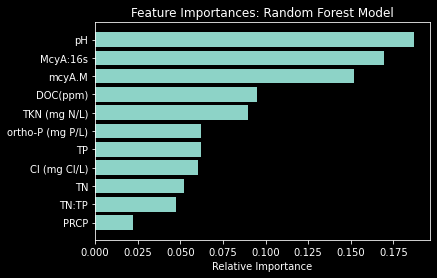

In [24]:
rf_feature_importances = rf_classifier.feature_importances_
indices = np.argsort(rf_feature_importances)

plt.title('Feature Importances: Random Forest Model')
plt.barh(range(len(indices)), rf_feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [boruta_selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


## Compared to Random Forest without parameter pre-selection


In [26]:
x_training_2, x_test_2, y_training_2, y_test_2 = train_test_split(x, y,
                                                          test_size=0.30,
                                                          stratify=y)
rf_classifier_2 = RandomForestClassifier(random_state = 489,
                                       max_depth=5,
                                       n_jobs=-1,
                                       class_weight='balanced',
                                       n_estimators=1000)
rf_classifier_2.fit(x_training_2, y_training_2)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=1000,
                       n_jobs=-1, random_state=489)

In [27]:
print('Dimensions:')
print('X_filtered:\t{}\tX_training {}\tX_testing: {}'.format(x_filtered.shape, x_training.shape, x_test.shape))
print('Y:\t\t{}\t\tY_training {}\tY_testing: {}'.format(y.shape, y_training.shape, y_test.shape))

Dimensions:
X_filtered:	(248, 11)	X_training (173, 11)	X_testing: (75, 11)
Y:		(248,)		Y_training (173,)	Y_testing: (75,)


## Predictions

In [28]:
predictions_2 = rf_classifier_2.predict(x_test_2)
training_score_2 = rf_classifier_2.score(x_training_2, y_training_2)
oob_score_2 = rf_classifier_2.oob_score
test_score_2 = rf_classifier_2.score(x_test_2, y_test_2)

print('Random forest classifier performance:')
print('\tTraining set: {}'.format(training_score_2))
print('OOB score: {}'.format(oob_score_2))
print('\tTest set: {}'.format(test_score_2))

Random forest classifier performance:
	Training set: 0.9826589595375722
OOB score: False
	Test set: 0.8


## Regression: Predicting Microcystin 1 Week Ahead

In [29]:
drop_cats_for_classification = [
                                'Collected Date', 'Environmental Location',
                                'Category', 'Week', 'Nearest Station',
                                'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'DATE',
                                'Category_1_ahead',
                                'Cylindrospermopsin',
                                'DNA Conc',
                                'Microcystin',
                                # '5d_PRCP_rm', '7d_PRCP_rm',
                                # '5d_AWND_rm', '7d_AWND_rm',
                                # '3d_TAVG_rm', '5d_TAVG_rm', '7d_TAVG_rm',
                                # 'TOBS', 'TAVG', 'TMAX', 'TMIN'
                                ]
target = 'Microcystin_1_ahead'



In [30]:
x_pre = combined.drop(columns=drop_cats_for_classification, axis=1).dropna()
y = x_pre[target].values
x = x_pre.drop(columns=[target], axis = 1).values

min_max_scaler = preprocessing.StandardScaler()
x = min_max_scaler.fit_transform(x)

y = y.ravel()

In [31]:
print('Number of categories dropped: {}'.format(len(drop_cats_for_classification)))
print(combined.shape)
print(x.shape)
print(y.shape)

Number of categories dropped: 14
(364, 34)
(248, 19)
(248,)


## Boruta feature selection

In [32]:
rf = RandomForestRegressor(n_jobs=-1,
                           # class_weight='balanced',
                           max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto',
                         verbose=0,
                         max_iter=100,
                         random_state=489)


feat_selector.fit(x, y)


BorutaPy(estimator=RandomForestRegressor(max_depth=5, n_estimators=56,
                                         n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x2630C893140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2630C893140)

In [33]:
# for i, cat in enumerate(list(x_pre)):
#     print('{}\t{}'.format(i, cat))

In [34]:
## Adding TN:TP, PRCP manually
add_boruta_feature(feat_selector, list(x_pre).index('TN:TP Other'))
# add_boruta_feature(feat_selector, -1)

kept_categories = feat_selector.support_ | feat_selector.support_weak_
boruta_selected_features = list(compress(list(x_pre.drop(columns=[target], axis=1)), kept_categories))

print('kept_categories\t{}\nsupport\t{}\nweak_support\t{}'.format(
    sum(kept_categories), sum(feat_selector.support_), sum(feat_selector.support_weak_)
))

print('The features selected as important by Boruta were: \n\t{}'.format(
    '\n\t'.join(boruta_selected_features)
))


kept_categories	5
support	4
weak_support	1
The features selected as important by Boruta were: 
	mcyA.M
	pH
	TN:TP Other
	McyA:16s
	PRCP


In [35]:
x_filtered = feat_selector.transform(x, weak=True)
print('Number of paramaters before Boruta selection: {}'.format(x.shape[1]))
print('Number of paramaters after Boruta selection: {}'.format(x_filtered.shape[1]))

Number of paramaters before Boruta selection: 19
Number of paramaters after Boruta selection: 5


## Random Forest Training

In [36]:
from sklearn.model_selection import train_test_split
x_training, x_test, y_training, y_test = train_test_split(x_filtered, y,
                                                          test_size=0.30)

print('Dimensions:')
print('X_filtered:\t{}\tX_training {}\tX_testing: {}'.format(x_filtered.shape, x_training.shape, x_test.shape))
print('Y:\t\t{}\t\tY_training {}\tY_testing: {}'.format(y.shape, y_training.shape, y_test.shape))

Dimensions:
X_filtered:	(248, 5)	X_training (173, 5)	X_testing: (75, 5)
Y:		(248,)		Y_training (173,)	Y_testing: (75,)


In [37]:
rf_regressor = RandomForestRegressor(random_state = 489,
                                       max_depth=5,
                                       n_jobs=-1,
                                       n_estimators=1000)

rf_regressor.fit(x_training, y_training)
predictions = rf_regressor.predict(x_test)

In [38]:
training_score = rf_regressor.score(x_training, y_training)
oob_score = rf_regressor.oob_score
test_score = rf_regressor.score(x_test, y_test)

print('Random forest regressor performance:')
print('\tTraining set: {}'.format(training_score))
print('OOB score: {}'.format(oob_score))
print('\tTest set: {}'.format(test_score))

Random forest regressor performance:
	Training set: 0.8817012078131681
OOB score: False
	Test set: 0.13846453583176987


### Feature importances

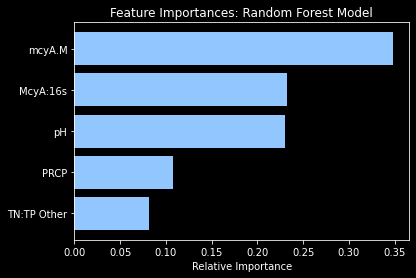

In [39]:
rf_feature_importances = rf_regressor.feature_importances_
indices = np.argsort(rf_feature_importances)
plt.style.use('seaborn-pastel')
plt.title('Feature Importances: Random Forest Model')
plt.barh(range(len(indices)), rf_feature_importances[indices], align='center')
plt.yticks(range(len(indices)), [boruta_selected_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


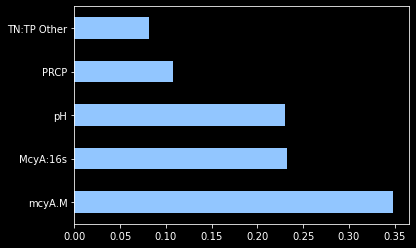

In [40]:
feat_importances = pd.Series(rf_feature_importances, index=boruta_selected_features)
feat_importances.nlargest(5).plot(kind='barh');